Implementation of [Rodriguez](https://ieeexplore.ieee.org/document/5475260) (sec. IV B)

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from rodriguez import downsampling, fir_filter, segmented_phase_estimation, generate_single_tone, insert_cut
from scipy.stats import beta
from sklearn.metrics import roc_curve
from tqdm import tqdm

In [14]:
# CONSTANTS
# random
SEED = 0

NOMINAL_ENF = 50
PM_NOMINAL = .2
F_DS = 1_000
DURATION = 20
AMPLITUDE = 1

N_DFT = 20_000

NUM_CYCLES = 10

CUT_SAMPLES_LIMIT = 1 * F_DS # 50 nominal enf cycles

np.random.seed(SEED)

In [15]:
# CALC FEATURE
def calc_feature(phases):
    phi_diff = np.diff(phases)
    m_phi_diff = np.mean(phi_diff)
    F = 100*np.log(np.mean((phi_diff-m_phi_diff)**2))
    return F


def random_signal(with_cut=True):
    m = DURATION * F_DS

    # random generation
    f_tone = NOMINAL_ENF - PM_NOMINAL + 2 * PM_NOMINAL * beta.rvs(2, 2)
    phi_0 = np.random.uniform(0, 2 * np.pi)
    if with_cut:
        i_cut = np.random.randint(0, m)
        cut_len = np.random.randint(0, CUT_SAMPLES_LIMIT)  # in samples

        n = np.arange(m + cut_len)
        n = np.delete(n, slice(i_cut, i_cut + cut_len))
    else:
        n = np.arange(m)

    sig = AMPLITUDE * np.cos((2 * np.pi * f_tone) * (n / F_DS) + phi_0)

    return sig

In [16]:
# MAIN
sig = random_signal(False)
phases = segmented_phase_estimation(sig, F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF)
feature = calc_feature(phases)
print(feature)

-3199.3232667409266


# Training

In [17]:
# Generate data
num_samples = 40
class_1_data = [random_signal(with_cut=False) for _ in range(num_samples)]
class_2_data = [random_signal(with_cut=True) for _ in range(num_samples)]


In [18]:
# Calculate features
class_1_features = [
    calc_feature(segmented_phase_estimation(signal, F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF))
    for signal in class_1_data
]
class_2_features = [
    calc_feature(segmented_phase_estimation(signal, F_DS, NUM_CYCLES, N_DFT, NOMINAL_ENF))
    for signal in class_2_data
]

In [19]:
# Labels: 0 for class 1, 1 for class 2
labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples)])
features = np.concatenate([class_1_features, class_2_features])

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(labels, features)

# Determine EER
eer = fpr[np.nanargmin(np.absolute((1 - tpr) - fpr))]
eer_threshold = thresholds[np.nanargmin(np.absolute((1 - tpr) - fpr))]

print(f"Equal Error Rate (EER): {eer}")
print(f"Threshold at EER: {eer_threshold}")

Equal Error Rate (EER): 0.0
Threshold at EER: -1038.9959605322315


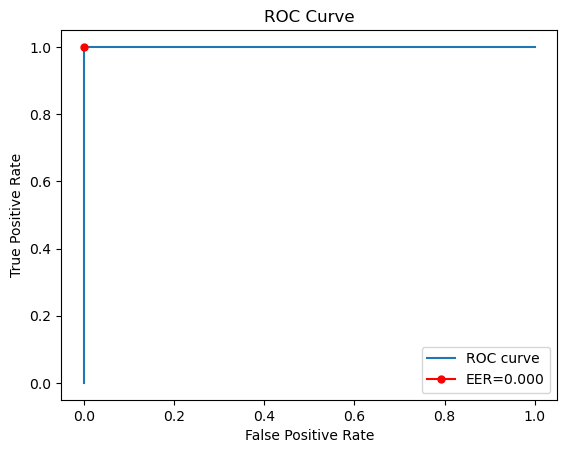

In [20]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([eer], [1 - eer], marker="o", markersize=5, color="red", label=f"EER={eer:.3f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()

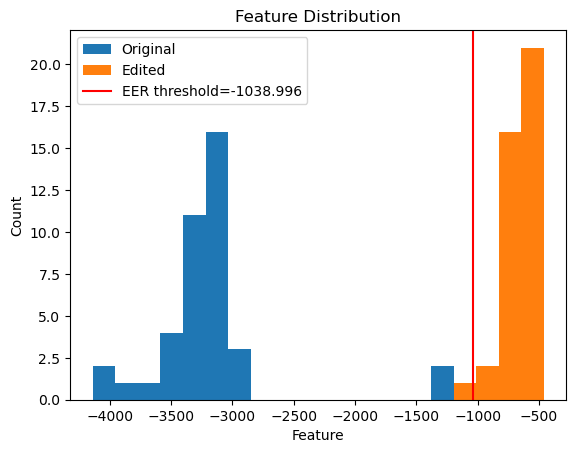

In [21]:
min_val = np.min(features)
max_val = np.max(features)

bins = np.linspace(min_val, max_val, 21)  # 20 Bins

plt.hist(class_1_features, bins=bins, label="Original")
plt.hist(class_2_features, bins=bins, label="Edited")
plt.axvline(eer_threshold, color="red", label=f"EER threshold={eer_threshold:.3f}")
plt.xlabel("Feature")
plt.ylabel("Count")
plt.title("Feature Distribution")
plt.legend(loc="best")
plt.show()